In [1]:
import pandas as pd
import numpy as np
import astropy.utils.data
from astropy.coordinates import SkyCoord,concatenate
import astropy.units as u
import datetime as _datetime
from astropy.io import fits as _fits
from astropy.coordinates import FK5,ICRS
from astropy.io import ascii
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time
from astropy.coordinates import search_around_sky
from astropy.table import unique, Table
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import time, coordinates as coord, units as u



pd.set_option('display.max_columns', None)

In [2]:
'''
---------------------------------------------------------------------
Reading in the GW coordinates - events e1 and e2 
e1: S190728q
e2: S200129m
---------------------------------------------------------------------
''' 

e1 = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/S190728q/50prob/s190728q_50prob_4096.csv')
e2 = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/S200129m/50prob/s200129m_50prob_4096.csv')

# Adding in an identifier for each source 
# -------------------------------------------------------------------
e1_details = []
for i in range(0, len(e1)):
    num = str(i)
    e1_details = np.append(e1_details, ['190728_'+num])
    
e1 = Table.from_pandas(e1)
e1.add_column(e1_details, name = 'our_id')
e1 = e1.to_pandas()

e2_details = []
for i in range(0, len(e2)):
    num = str(i)
    e2_details = np.append(e2_details, ['200129m_'+num])
    
e2 = Table.from_pandas(e2)
e2.add_column(e2_details, name = 'our_id')
e2 = e2.to_pandas()

# Printing/Saving the max and min values for RA, DEC for each source
# -------------------------------------------------------------------
min_ra_e1 = min(e1['ra'])
max_ra_e1 = max(e1['ra'])
min_dec_e1 = min(e1['dec'])
max_dec_e1 = max(e1['dec'])

min_ra_e2 = min(e2['ra'])
max_ra_e2 = max(e2['ra'])
min_dec_e2 = min(e2['dec'])
max_dec_e2 = max(e2['dec'])

# Combining the two sources and saving it to a file for further xmatching 
# -------------------------------------------------------------------
e_results = pd.concat([e1, e2], axis=0)
e_results.to_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw/combined_gw.csv')

# Defining the SkyCoord object for GW sources, for later use
# -------------------------------------------------------------------
# gw_coord = SkyCoord(e_results.ra, e_results.dec, unit='deg')


'''
---------------------------------------------------------------------
Status after this cell:
---------------------------------------------------------------------
We have a combined_GW file, with identifiers for each source; 
We have defined the GW SkyCoord object;
'''

'\n---------------------------------------------------------------------\nStatus after this cell:\n---------------------------------------------------------------------\nWe have a combined_GW file, with identifiers for each source; \nWe have defined the GW SkyCoord object;\n'

In [3]:
'''
---------------------------------------------------------------------
Reading in the GLADE+ coordinates, crossmatched with combined_GW
---------------------------------------------------------------------
- Script is on ilifu, GLADE+_xmatching.ipynb 
- Bash script 'xmatch; (local) fetches relevant lines from the larger GLADE+ catalog
---------------------------------------------------------------------
'''

# GLADE+ matches for each GW source
# ---------------------------------------------------------------------
e1_gp = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog/s190728q_gp.csv')
e2_gp = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog/s200129m_gp.csv')

print('GLADE+ sources for S190728q: ', len(e1_gp))
print('GLADE+ sources for S200129m: ', len(e2_gp))

# Joining the GLADE+ matches for both sources 
# ---------------------------------------------------------------------
gp_results = pd.concat([e1_gp, e2_gp], axis=0)
gp_results = gp_results.reset_index(drop=True)

# Reading in the GLADE+ sources from the full catalog 
# ---------------------------------------------------------------------
gw_gp_xmatch = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_gp/complete_xmatch_gw_gp.csv')

print('Number of GLADE_sources for both GW sources: ', len(gw_gp_xmatch))

# Modifying the table
# ---------------------------------------------------------------------
gw_gp_xmatch = gw_gp_xmatch['GLADE_num PGC_num GWGC_name HyperLEDA_name 2MASS_name WISExSCOS_name SDSS_DR16Q_name Object_type_flag RA Dec B B_err B_flag B_Abs J J_err H H_err K K_err W1 W1_err W2 W2_err W1_flag B_I B_I_err z_helio z_cmb z_flag d_L d_L_err dist_flag M_star M_star_flag merger_rate merger_rate_err'].str.split(' ', expand=True)

gw_gp_xmatch.rename(columns = {0:'GLADE_num', 
                        1: 'PGC_num',
                        2: 'GWGC_name',
                        3:'HyperLEDA_name', 
                        4: '2MASS_name',
                        5: 'WISExSCOS_name',
                        6: 'SDSS_DR16Q_name',
                        7: 'Object_type_flag',
                        8: 'RA', 
                        9: 'Dec',
                        10: 'B',
                        11: 'B_err',
                        12: 'B_flag', 
                        13: 'B_Abs',
                        14: 'J',
                        15: 'J_err',
                        16: 'H',
                        17: 'H_err', 
                        18: 'K', 
                        19: 'K_err',
                        20: 'W1', 
                        21: 'W1_err', 
                        22: 'W2', 
                        23: 'W2_err', 
                        24: 'W1_flag',
                        25: 'B_I', 
                        26: 'B_I_err', 
                        27: 'z_helio', 
                        28: 'z_cmb', 
                        29: 'z_flag',
                        30: 'd_L',
                        31: 'd_L_err',
                        32: 'dist_flag',
                        33: 'M_star',
                        34: 'M_star_flag',
                        35: 'merger_rate',
                        36: 'merger_rate_err',
                        37:'37', 
                        38: '38',
                        39: '39'
                       }, inplace = True)


# Removing quasers and quaser-like objects 
# ---------------------------------------------------------------------
gw_gp_xmatch = gw_gp_xmatch[gw_gp_xmatch['Object_type_flag']!='Q']

print('Number of GLADE_sources for both GW sources, after removing quasers: ', len(gw_gp_xmatch))

# Renaming the RA, Dec columns to avoid duplicates
# ---------------------------------------------------------------------
gw_gp_xmatch.rename(columns={'RA':'RA_GLADE'}, inplace=True)
gw_gp_xmatch.rename(columns={'Dec':'Dec_GLADE'}, inplace=True)

# Adding a 'source' column  
# ---------------------------------------------------------------------
glade_source = list(['glade'] * len(gw_gp_xmatch))
gw_gp_xmatch['source'] = glade_source

# # Converting to an Astropy Table for easier access into the PS1 DR2 CasJobs platform
# # ---------------------------------------------------------------------
# gw_gp_xmatch_t = Table.from_pandas(gw_gp_xmatch)

# gw_gp_xmatch_t['RA_GLADE'] = gw_gp_xmatch_t['RA_GLADE'].astype(float)
# gw_gp_xmatch_t['Dec_GLADE'] = gw_gp_xmatch_t['Dec_GLADE'].astype(float)

# gw_gp_xmatch_ = Table(gw_gp_xmatch_t[0:0])

# # Since we chose a square initially, there are many sources outside the GW contours which we do not want;
# # Limiting the GLADE+ sources to fit in the GW contours
# # ---------------------------------------------------------------------
# for i in range(0, len(gw_gp_xmatch_t)):
#     if gw_gp_xmatch_t['RA_GLADE'][i] < 321.031494140625 and gw_gp_xmatch_t['RA_GLADE'][i] > 311.517333984375 and gw_gp_xmatch_t['Dec_GLADE'][i] < 18.406411043688017 and gw_gp_xmatch_t['Dec_GLADE'][i] > 1.3243367823729182:
#         gw_gp_xmatch_.add_row(gw_gp_xmatch_t[i])

# print('Number of GLADE_sources for both GW sources, after removing quasers, and fitting in the GW contours: ', len(gw_gp_xmatch_))

# gw_gp_xmatch.write("/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_gp/gw_gp.csv", format="csv", overwrite=True)


# Cross-matching the above gw_gp.csv file with the combined_GW file in CDS
# Within 1 arc-min
# We also retrieve 'our_id' this way;
# ---------------------------------------------------------------------
gw_gp_xmatch = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_gp/cds_gp_gw_1arcmin.csv')
print('Final Number of GLADE+ sources, after fitting to GW contours: ', len(gw_gp_xmatch))

'''
---------------------------------------------------------------------
Status after this cell:
---------------------------------------------------------------------
We have two GLADE+ catalogs (original and optimized)-
first, we matched each GW coordinate with the optimized GLADE+ catalog in ilifu;
second, we took those matches and ran a bash script to get back all the original columns in the original catalog;

Finally, we have a xmatch between GW and the original GLADE+ catalog;

gw_gp.csv: GW_combined + GLADE+ sources
'''

GLADE+ sources for S190728q:  130962
GLADE+ sources for S200129m:  26896
Number of GLADE_sources for both GW sources:  28368
Number of GLADE_sources for both GW sources, after removing quasers:  26841
Final Number of GLADE+ sources, after fitting to GW contours:  18196


/tmp/ipykernel_123165/3354621019.py:112: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  gw_gp_xmatch = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_gp/cds_gp_gw_1arcmin.csv')


'\n---------------------------------------------------------------------\nStatus after this cell:\n---------------------------------------------------------------------\nWe have two GLADE+ catalogs (original and optimized)-\nfirst, we matched each GW coordinate with the optimized GLADE+ catalog in ilifu;\nsecond, we took those matches and ran a bash script to get back all the original columns in the original catalog;\n\nFinally, we have a xmatch between GW and the original GLADE+ catalog;\n\ngw_gp.csv: GW_combined + GLADE+ sources\n'

In [4]:
gw_gp_xmatch

,angDist,index,hp,ra,dec,our_id,GLADE_num,PGC_num,GWGC_name,HyperLEDA_name,2MASS_name,WISExSCOS_name,SDSS_DR16Q_name,Object_type_flag,RA_GLADE,Dec_GLADE,B,B_err,B_flag,B_Abs,J,J_err,H,H_err,K,K_err,W1,W1_err,W2,W2_err,W1_flag,B_I,B_I_err,z_helio,z_cmb,z_flag,d_L,d_L_err,dist_flag,M_star,M_star_flag,merger_rate,merger_rate_err,37,38,39
0,29.159244,12076,78363657,319.207764,3.022859,200129m_12076,19651226,NaN,NaN,NaN,NaN,J211649.57+030053.4,NaN,G,319.206561,3.014849,20.347038,NaN,1,-19.5650,NaN,NaN,NaN,NaN,NaN,NaN,15.329000,0.041,15.018,0.079,0,19.843000,0.069,0.190748,0.189555,NaN,NaN,0.039295,960.312764,NaN,1,3.0,2.0,1.0,NaN,NaN
1,59.976221,12076,78363657,319.207764,3.022859,200129m_12076,19651228,NaN,NaN,NaN,NaN,J211646.84+030042.8,NaN,G,319.195208,3.011889,20.409195,NaN,1,-20.1868,NaN,NaN,NaN,NaN,NaN,NaN,15.458000,0.042,15.029,0.079,0,19.969999,0.072,0.252491,0.251257,NaN,NaN,0.041332,1315.842939,NaN,1,5.0,3.0,1.0,NaN,NaN
2,19.411051,12079,78363669,319.295654,3.060214,200129m_12079,19651237,NaN,NaN,NaN,NaN,J211710.15+030352,NaN,G,319.292322,3.064457,21.481268,NaN,1,-19.7208,NaN,NaN,NaN,NaN,NaN,NaN,15.448000,0.044,15.380,0.098,0,20.924000,0.111,0.322082,0.320797,NaN,NaN,0.043629,1739.491794,NaN,1,7.0,4.0,NaN,NaN,NaN
3,36.340739,12080,78363673,319.251709,3.060214,200129m_12080,19651206,NaN,NaN,NaN,NaN,J211658.46+030315,NaN,G,319.243610,3.054173,20.060190,NaN,1,-20.1868,NaN,NaN,NaN,NaN,NaN,NaN,14.543000,0.031,14.064,0.042,0,19.575001,0.066,0.218992,0.217780,NaN,NaN,0.040227,1120.471270,NaN,1,9.0,5.0,NaN,NaN,NaN
4,36.340739,12080,78363673,319.251709,3.060214,200129m_12080,19651206,NaN,NaN,NaN,NaN,J211658.46+030315,NaN,G,319.243610,3.054173,20.060190,NaN,1,-20.1868,NaN,NaN,NaN,NaN,NaN,NaN,14.543000,0.031,14.064,0.042,0,19.575001,0.066,0.218992,0.217780,NaN,NaN,0.040227,1120.471270,NaN,1,9.0,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18191,47.073678,7794,50550721,317.471924,7.349973,200129m_7794,524000,NaN,NaN,SDSSJ210950.08+072109.2,NaN,J210950.10+072110.4,NaN,G,317.459000,7.352560,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.871000,NaN,14.746,NaN,0,NaN,NaN,0.363889,0.362590,0.0,NaN,0.045008,2004.860530,NaN,1,15.0,7.0,1.0,NaN,NaN
18192,29.824529,409,50401925,318.284912,3.247006,200129m_409,19556827,NaN,NaN,NaN,NaN,J211310.29+031441.1,NaN,G,318.292900,3.244763,21.553284,NaN,1,-19.6190,NaN,NaN,NaN,NaN,NaN,NaN,15.443000,0.040,15.105,0.079,0,20.993000,0.117,0.318281,0.317010,NaN,NaN,0.043503,1715.757908,NaN,1,7.0,4.0,1.0,NaN,NaN
18193,30.046123,410,50401929,318.240967,3.247006,200129m_410,19556826,NaN,NaN,NaN,NaN,J211256.74+031514.4,NaN,G,318.236424,3.254013,20.663506,NaN,1,-19.5119,NaN,NaN,NaN,NaN,NaN,NaN,15.455000,0.041,15.222,0.086,0,20.156000,0.076,0.212650,0.211454,NaN,NaN,0.040017,1084.139162,NaN,1,4.0,2.0,1.0,NaN,NaN
18194,41.304878,410,50401929,318.240967,3.247006,200129m_410,19556833,NaN,NaN,NaN,NaN,J211300.36+031432.8,NaN,G,318.251523,3.242470,20.015219,NaN,1,-18.9670,NaN,NaN,NaN,NaN,NaN,NaN,15.804000,0.052,15.694,0.139,0,19.580999,0.066,0.129066,0.127922,NaN,NaN,0.037259,625.821246,NaN,1,1.0,0.7,1.0,NaN,NaN


In [40]:
'''
---------------------------------------------------------------------
Reading in the PS1 DR2 and GW xmatch 
---------------------------------------------------------------------
- Ran on the CasJobs platform 
- Specified a large square region (defined by the RA, Dec limits of the GW sources)
- Need to limit the PS1 DR2 sources to the GW contours
---------------------------------------------------------------------
'''

gw_ps1_xmatch = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/combined_gw_ps.csv')
print('Number of PS1 DR2 sources:', len(gw_ps1_xmatch))

# Removing duplicate object IDs
# ---------------------------------------------------------------------
gw_ps1_xmatch.drop_duplicates('objID', keep='first', inplace=True)
print('Number of PS1 DR2 sources after removing duplicates:', len(gw_ps1_xmatch))

# Adding a 'source' column  
# ---------------------------------------------------------------------
ps_source = list(['ps'] * len(gw_ps1_xmatch))
gw_ps1_xmatch['source'] = ps_source

# # Limiting the PS1 DR2 sources to fit in the GW contours
# # ---------------------------------------------------------------------
# gw_ps1_xmatch_t = Table.from_pandas(gw_ps1_xmatch)
# gw_ps1_xmatch_ = Table(gw_ps1_xmatch_t[0:0])

# for i in range(0, len(gw_ps1_xmatch_t)):
#     if gw_ps1_xmatch_t['raMean'][i] < 321.031494140625 and gw_ps1_xmatch_t['raMean'][i] > 311.517333984375 and gw_ps1_xmatch_t['decMean'][i] < 18.406411043688017 and gw_ps1_xmatch_t['decMean'][i] > 1.3243367823729182:
#         gw_ps1_xmatch_.add_row(gw_ps1_xmatch_t[i])
        
# print('Number of PS1 DR2 sources after fitting in the GW contours:', len(gw_ps1_xmatch_))


# gw_ps1_xmatch.write("/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_ps/gw_ps1.csv", format="csv", overwrite=True)


# Cross-matching the above gw_ps1.csv file with the combined_GW file in CDS
# Within 1 arc-min
# We also retrieve 'our_id' this way;
# ---------------------------------------------------------------------
gw_ps1_xmatch_ = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_ps/cds_ps1_gw_1arcmin.csv')
print('Final Number of PS1 DR2 sources, after fitting to GW contours: ', len(gw_ps1_xmatch_))

'''
---------------------------------------------------------------------
Status after this cell:
---------------------------------------------------------------------
We run a CasJobs query in PS1 DR2 with the RA, Dec limits of the GW sources;
We have read the results in here, and will limit the sources to the GW contours;

gw_ps1.csv: GW_combined + PS1 DR2 sources
'''

Number of PS1 DR2 sources: 86579
Number of PS1 DR2 sources after removing duplicates: 86579
Final Number of PS1 DR2 sources, after fitting to GW contours:  14158


'\n---------------------------------------------------------------------\nStatus after this cell:\n---------------------------------------------------------------------\nWe run a CasJobs query in PS1 DR2 with the RA, Dec limits of the GW sources;\nWe have read the results in here, and will limit the sources to the GW contours;\n\ngw_ps1.csv: GW_combined + PS1 DR2 sources\n'

In [41]:
gw_ps1_xmatch

,objName,objNameHMS,objAltName1,objAltName2,objAltName3,objPopularName,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,tessID,projectionID,skyCellID,randomID,batchID,dvoRegionID,processingVersion,objInfoFlag,astrometryCorrectionFlag,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,raMeanErr,decMeanErr,pmra,pmdec,pmraErr,pmdecErr,epochMean,posMeanChisq,cx,cy,cz,lambda,beta,l,b,nStackObjectRows,nStackDetections,nDetections,ng,nr,ni,nz,ny,Column1,Column2,gQfPerfect,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagStd,gMeanPSFMagNpt,gMeanPSFMagMin,gMeanPSFMagMax,gMeanKronMag,gMeanKronMagErr,gMeanKronMagStd,gMeanKronMagNpt,gMeanApMag,gMeanApMagErr,gMeanApMagStd,gMeanApMagNpt,gFlags,rQfPerfect,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagStd,rMeanPSFMagNpt,rMeanPSFMagMin,rMeanPSFMagMax,rMeanKronMag,rMeanKronMagErr,rMeanKronMagStd,rMeanKronMagNpt,rMeanApMag,rMeanApMagErr,rMeanApMagStd,rMeanApMagNpt,rFlags,iQfPerfect,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagStd,iMeanPSFMagNpt,iMeanPSFMagMin,iMeanPSFMagMax,iMeanKronMag,iMeanKronMagErr,iMeanKronMagStd,iMeanKronMagNpt,iMeanApMag,iMeanApMagErr,iMeanApMagStd,iMeanApMagNpt,iFlags,zQfPerfect,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagStd,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,zMeanKronMag,zMeanKronMagErr,zMeanKronMagStd,zMeanKronMagNpt,zMeanApMag,zMeanApMagErr,zMeanApMagStd,zMeanApMagNpt,zFlags,yQfPerfect,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagStd,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax,yMeanKronMag,yMeanKronMagErr,yMeanKronMagStd,yMeanKronMagNpt,yMeanApMag,yMeanApMagErr,yMeanApMagStd,yMeanApMagNpt,yFlags,source
0,PSO J319.9352+01.3361,PSX J211944.44+012009.9,-999,-999,-999,-999,109603199351963789,3590364000038278,79486959785349,0,13333655086354,10960,1,1402,35,0.447524,3590364,18507,3,512024576,7,61,319.935205,1.336110,0.001,0.001,319.935199,1.336108,0.001019,0.001019,2.745556,-0.636687,0.688741,0.688741,56178.468120,11.944426,0.765109,-0.643479,0.023317,322.783105,16.102365,53.265197,-31.720016,-999,5,77,12,12,29,14,10,109603199351963789,3590364000038278,0.999556,19.545900,0.028996,0.094516,9,19.338800,19.607700,19.054100,0.027263,0.080637,11,19.080400,0.041038,0.104044,11,16892216,0.999745,18.717100,0.026422,0.094465,11,18.557800,18.820400,18.041201,0.013136,0.042251,12,18.145000,0.011901,0.039090,12,16892216,0.999643,18.172501,0.021599,0.092339,18,17.992399,18.307100,17.613001,0.008841,0.037109,23,17.729900,0.010305,0.043557,23,16892216,0.999686,17.908300,0.025328,0.090134,9,17.705700,17.982800,17.394800,0.008128,0.025280,11,17.442900,0.013140,0.032995,11,16892216,0.999478,17.681200,0.031910,0.063165,6,17.570900,17.733500,17.215099,0.030189,0.087010,10,17.254299,0.032360,0.119007,10,16892216,ps
1,PSO J317.5315+01.3444,PSX J211007.55+012039.8,-999,-999,-999,-999,109613175315093771,3590024000026279,79207786899111,0,13335471852783,10961,1,1401,31,0.494610,3590024,18442,3,512024576,7,61,317.531484,1.344435,0.001,0.001,317.531490,1.344405,0.001843,0.001843,9.490347,20.886890,1.202415,1.202415,56292.170640,36.681894,0.737445,-0.674999,0.023462,320.404665,16.859467,51.751299,-29.699875,-999,5,68,7,14,23,10,14,109613175315093771,3590024000026279,0.999361,19.955999,0.154080,0.403461,6,19.472601,20.490700,17.828699,0.033046,0.056201,6,18.664101,0.149399,0.386111,6,16892216,0.999196,19.484400,0.048716,0.173166,9,19.403299,19.773800,17.292000,0.016585,0.050895,11,18.276800,0.042199,0.097631,11,16892216,0.999705,18.879801,0.083353,0.317713,18,18.515400,19.444401,16.934999,0.009539,0.050376,20,17.680099,0.067104,0.242572,20,16892216,0.999724,18.686100,0.036067,0.147533,9,18.554199,18.910500,16.962601,0.024483,0.118774,9,17.561899,0.040503,0.079709,9,16892216,0.999199,18.723400,0.064775,0.206296,9,18.356800,19.095800,17.277700,0.024544,0.081731,14,17.683201,0.075983,0.204941,14,16892216,ps
2,PSO J320.8332+01.3262,PSX J212319.96+011934.2,-999,-999,-999,-999,109593208331111888,3590497000027759,79753247747182,0,13346789009682,10959,1,1402,32,0.992806,3590497,18569,3,512024576,7,61,320.833132,1.32619

Total number of sources (GLADE+ and PS1 DR2):  32354


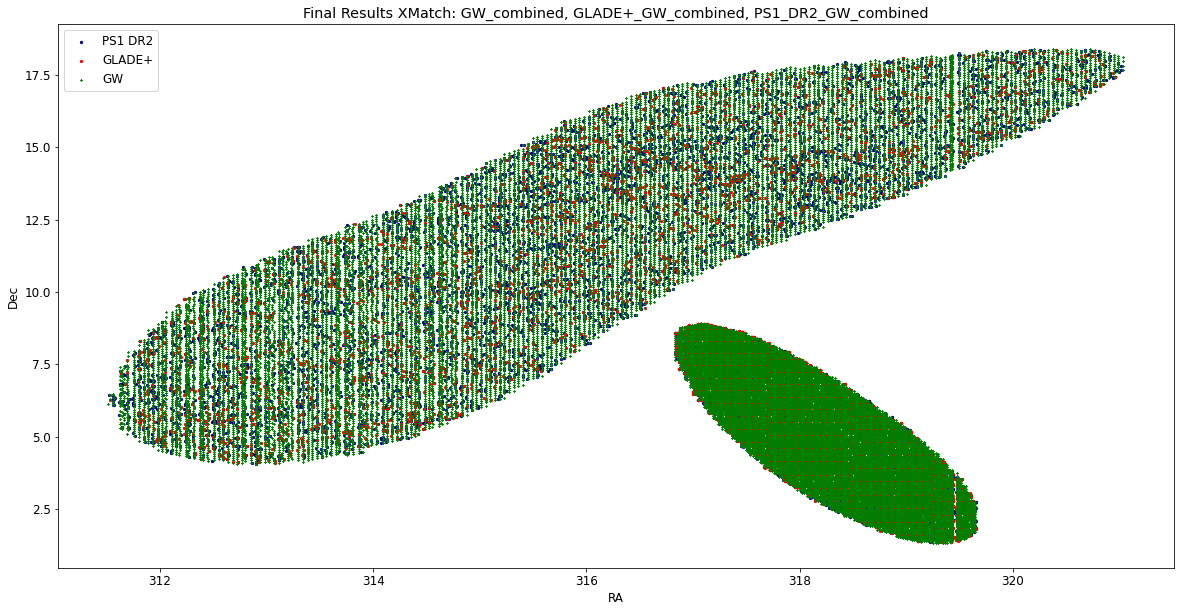

In [42]:
'''
---------------------------------------------------------------------
Combining GLADE+ and PS1 DR2 sources (and GW_combined)
---------------------------------------------------------------------
- Now we want to combine all the sources we have so far 
(GW + GLADE+ + PS1 DR2)
- Save the combined catalog of GLADE+ sources and PS1 DR2 sources
- Upload this to CasJobs to perform a crossmatch between GLADE+ and PS1 DR2
- Also make a sanity plot 
---------------------------------------------------------------------
'''
# gw_ps1_xmatch_ = gw_ps1_xmatch_.to_pandas()
# gw_gp_xmatch_ = gw_gp_xmatch_.to_pandas()

final_results = pd.concat([gw_ps1_xmatch_, gw_gp_xmatch], axis=0)
final_results = final_results.reset_index(drop=True)

print('Total number of sources (GLADE+ and PS1 DR2): ', len(final_results))

# Removing duplicates (PS1 DR2 objID and GLADE_num)
# ---------------------------------------------------------------------
# final_results.drop_duplicates('objID', keep='first', inplace=True)
# final_results.drop_duplicates('GLADE_num', keep='first', inplace=True)

# print('Total number of sources (GLADE+ and PS1 DR2) after removing duplicates: ', len(final_results))

# Saving the results to a file, to be cross-matched in GDR3
# ---------------------------------------------------------------------
final_results.to_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gw_gp_ps/combined_gw_gp_ps1.csv')

# Sanity Plots
# ---------------------------------------------------------------------
plt.figure(figsize=(20,10))
plt.scatter(gw_ps1_xmatch_['raMean'], gw_ps1_xmatch_['decMean'], label='PS1 DR2', s=5, c='darkblue')
plt.scatter(gw_gp_xmatch['RA_GLADE'], gw_gp_xmatch['Dec_GLADE'], label='GLADE+', s=5, c='red')
plt.scatter(e_results['ra'], e_results['dec'], label='GW', s=2, c='green', marker='x')
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("Final Results XMatch: GW_combined, GLADE+_GW_combined, PS1_DR2_GW_combined")
plt.legend()

In [8]:
final_results

,angDist,index,hp,ra,dec,our_id,objName,objNameHMS,objAltName1,objAltName2,objAltName3,objPopularName,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,tessID,projectionID,skyCellID,randomID,batchID,dvoRegionID,processingVersion,objInfoFlag,astrometryCorrectionFlag,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,raMeanErr,decMeanErr,pmra,pmdec,pmraErr,pmdecErr,epochMean,posMeanChisq,cx,cy,cz,lambda,beta,l,b,nStackObjectRows,nStackDetections,nDetections,ng,nr,ni,nz,ny,Column1,Column2,gQfPerfect,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagStd,gMeanPSFMagNpt,gMeanPSFMagMin,gMeanPSFMagMax,gMeanKronMag,gMeanKronMagErr,gMeanKronMagStd,gMeanKronMagNpt,gMeanApMag,gMeanApMagErr,gMeanApMagStd,gMeanApMagNpt,gFlags,rQfPerfect,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagStd,rMeanPSFMagNpt,rMeanPSFMagMin,rMeanPSFMagMax,rMeanKronMag,rMeanKronMagErr,rMeanKronMagStd,rMeanKronMagNpt,rMeanApMag,rMeanApMagErr,rMeanApMagStd,rMeanApMagNpt,rFlags,iQfPerfect,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagStd,iMeanPSFMagNpt,iMeanPSFMagMin,iMeanPSFMagMax,iMeanKronMag,iMeanKronMagErr,iMeanKronMagStd,iMeanKronMagNpt,iMeanApMag,iMeanApMagErr,iMeanApMagStd,iMeanApMagNpt,iFlags,zQfPerfect,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagStd,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,zMeanKronMag,zMeanKronMagErr,zMeanKronMagStd,zMeanKronMagNpt,zMeanApMag,zMeanApMagErr,zMeanApMagStd,zMeanApMagNpt,zFlags,yQfPerfect,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagStd,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax,yMeanKronMag,yMeanKronMagErr,yMeanKronMagStd,yMeanKronMagNpt,yMeanApMag,yMeanApMagErr,yMeanApMagStd,yMeanApMagNpt,yFlags,GLADE_num,PGC_num,GWGC_name,HyperLEDA_name,2MASS_name,WISExSCOS_name,SDSS_DR16Q_name,Object_type_flag,RA_GLADE,Dec_GLADE,B,B_err,B_flag,B_Abs,J,J_err,H,H_err,K,K_err,W1,W1_err,W2,W2_err,W1_flag,B_I,B_I_err,z_helio,z_cmb,z_flag,d_L,d_L_err,dist_flag,M_star,M_star_flag,merger_rate,merger_rate_err,37,38,39
0,44.811736,3120,50423641,318.988037,4.929937,200129m_3120,PSO J318.9959+04.9396,PSX J211559.02+045622.4,-999.0,-999.0,-999.0,-999.0,1.139232e+17,3.564893e+15,7.934093e+13,0.0,1.333394e+13,11392.0,1.0,1491.0,26.0,0.199725,3564893.0,18473.0,3.0,512024576.0,7.0,61.0,318.995930,4.939586,0.001,0.001,318.995928,4.939588,0.001516,0.001516,-4.092344,6.273140,0.987055,0.987055,56406.425853,56.582731,0.751860,-0.653676,0.086105,323.052630,19.817014,56.112279,-28.922313,-999.0,5.0,83.0,16.0,14.0,27.0,11.0,15.0,1.139232e+17,3.564893e+15,0.999675,19.842600,0.009391,0.040778,6.0,19.772900,19.874001,17.977699,0.016878,0.088417,12.0,18.708300,0.048701,0.192562,12.0,16892216.0,0.999649,19.269100,0.059344,0.214818,12.0,18.997700,19.580400,17.375700,0.012169,0.033126,11.0,18.110100,0.051925,0.165551,12.0,16892216.0,0.999765,18.905800,0.052522,0.220708,18.0,18.573400,19.259100,16.964800,0.006485,0.038354,26.0,17.700800,0.041635,0.200309,26.0,16892216.0,0.999446,18.644100,0.038008,0.116479,7.0,18.497000,18.850800,16.863400,0.012342,0.038155,10.0,17.580601,0.029161,0.092962,10.0,16892216.0,0.999011,18.380899,0.083156,0.325986,10.0,18.189600,19.018600,16.921900,0.067695,0.112875,13.0,17.271900,0.075554,0.214002,13.0,16892216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.109008,9855,51169638,314.879150,12.635625,190728_9855,PSO J314.8750+12.6252,PSX J205929.99+123730.8,-999.0,-999.0,-999.0,-999.0,1.231531e+17,3.594445e+15,1.185153e+14,0.0,1.415193e+13,12315.0,1.0,1667.0,15.0,0.101535,3594445.0,27594.0,3.0,512024576.0,7.0,61.0,314.874959,12.625273,0.001,0.001,314.874966,12.625259,0.002230,0.002230,-3.632758,3.797609,1.578703,1.579029,56072.556535,7.294313,0.688502,-0.691513,0.218573,321.507724,28.398767,60.415731,-21.146356,-999.0,5.0,78.0,12.0,11.0,23.0,16.0,16.0,1.231531e+17,3.594445e+15,0.998821,20.123301,0.037136,0.141771,10.0,19.929399,20.341999,19.802401,0.023037,0.074353,10.0,19.789801,0.020695,0.075220,10.0,16892216.0,0.998888,19.706499,0.016679,0.0538

In [7]:
'''
---------------------------------------------------------------------
Uploading our catalog to CasJobs and performing a crossmatch query between GLADE+ and PS1 DR2
---------------------------------------------------------------------
- As seen in the sanity plot above, the PS1 DR2 sources are in a large square around the required contours;
- We upload our catalog to CasJobs and search for PS1 DR2 sources 1 arc-sec around the GLADE+ sources
- This should help limit the sources to within the GW contours 
'''

# !!! This step is currently problematic !!!

# pd.read_csv()

'\n---------------------------------------------------------------------\nUploading our catalog to CasJobs and performing a crossmatch query between GLADE+ and PS1 DR2\n---------------------------------------------------------------------\n- As seen in the sanity plot above, the PS1 DR2 sources are in a large square around the required contours;\n- We upload our catalog to CasJobs and search for PS1 DR2 sources 1 arc-sec around the GLADE+ sources\n- This should help limit the sources to within the GW contours \n'

In [145]:
'''
---------------------------------------------------------------------
Query GDR3 on the Gaia Archive, via ADQL
---------------------------------------------------------------------
- Upload the combined GW+PS1+GLADE+ catalog to Gaia
- Search within a radius of 30 arc-sec 
---------------------------------------------------------------------
'''

# Reading in the GDR3 (Astrophysical Params) xmatch with PS1+GLADE+ in 1 arcmin 
# ---------------------------------------------------------------------
xmatch_all = pd.read_csv('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/gdr3/final_results_30arcsec.csv', engine='python')

xmatch_all.rename(columns={'ra':'ra_xmatch'}, inplace=True)
xmatch_all.rename(columns={'dec':'dec_xmatch'}, inplace=True)

xmatch_all.rename(columns={'ra.1':'ra_gaia'}, inplace=True)
xmatch_all.rename(columns={'dec.1':'dec_gaia'}, inplace=True)

print('All cross-matches: ', len(xmatch_all))

# Checking all the columns we have in our final catalog 
# ---------------------------------------------------------------------
print(xmatch_all.columns.tolist())

All cross-matches:  130325
['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra_xmatch', 'ra_error', 'dec_xmatch', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'ma

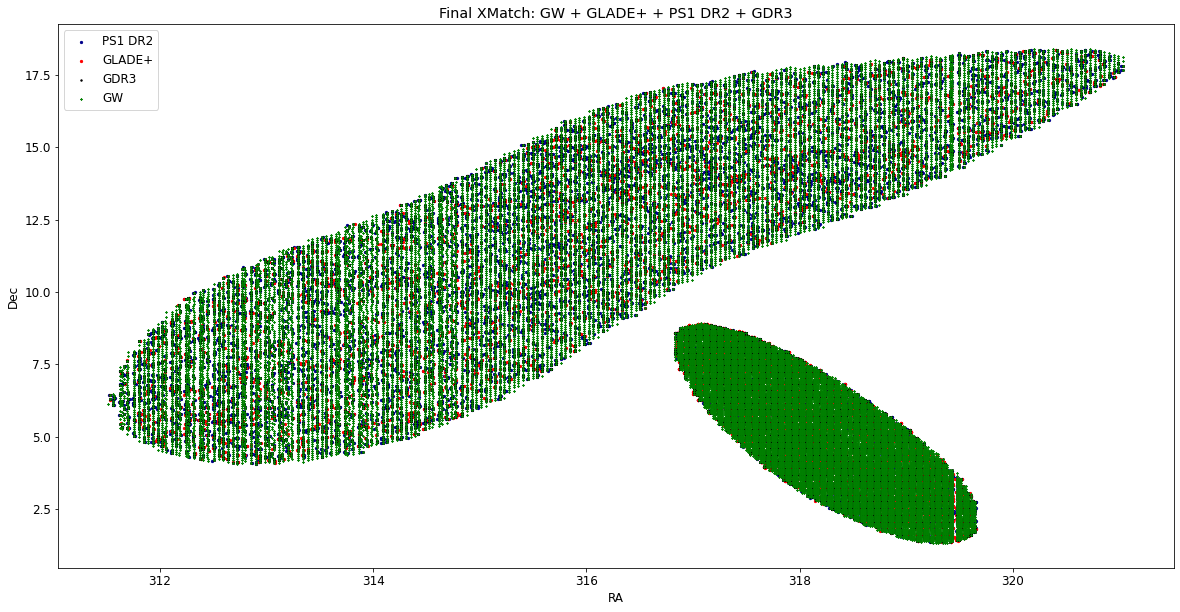

In [44]:
# Final Sanity Plot
# ---------------------------------------------------------------------
plt.figure(figsize=(20,10))
plt.scatter(gw_ps1_xmatch_['raMean'], gw_ps1_xmatch_['decMean'], label='PS1 DR2', s=5, c='darkblue')
plt.scatter(gw_gp_xmatch['RA_GLADE'], gw_gp_xmatch['Dec_GLADE'], label='GLADE+', s=5, c='red')
plt.scatter(xmatch_all['ra_gaia'], xmatch_all['dec_gaia'], label='GDR3', s=2, c='black')
plt.scatter(e_results['ra'], e_results['dec'], label='GW', s=2, c='green', marker='x')
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("Final XMatch: GW + GLADE+ + PS1 DR2 + GDR3")
plt.legend()

In [146]:
'''
If there are duplicate Gaia crossmatches, only take the closest one
'''

def sep(ra,dec,ra1,dec1):
    c1=SkyCoord(ra*u.deg, dec*u.deg)
    c2=SkyCoord(ra1*u.deg, dec1*u.deg)
    sep = c1.separation(c2)
    return sep.arcsecond

xmatch_all['separation'] = np.abs(sep(xmatch_all['ra_gaia'].values,xmatch_all['dec_gaia'].values,xmatch_all['ra_xmatch'].values,xmatch_all['dec_xmatch'].values))
xmatch_all = xmatch_all.sort_values('separation').drop_duplicates(subset='our_id', keep='first')

In [147]:
'''
---------------------------------------------------------------------
Defining functions for plotting the images (from Lana)
---------------------------------------------------------------------
'''

from __future__ import print_function
import numpy
from astropy.table import Table
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import pylab
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im

def getcolorim_1_arcsec(ra, dec, size=8*8, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im

def getcolorim_15_arcmin(ra, dec, size=7200*7200, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im

def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

Number of PS sources not cut, plus all GLADE sources :  13000


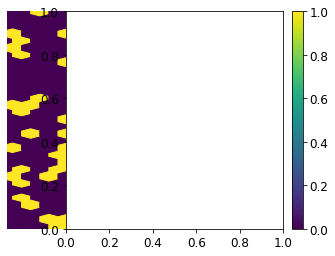

,solution_id,designation,source_id,random_index,ref_epoch,ra_xmatch,ra_error,dec_xmatch,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,table1_oid,col1,angdist,index,hp,ra_gaia,dec_gaia,our_id,objname,objnamehms,objaltname1,objaltname2,objaltname3,objpopularname,objid,uniquepspsobid,ippobjid,surveyid,htmid,zoneid,tessid,projectionid,skycellid,randomid,batchid,dvoregionid,processingversion,objinfoflag,astrometrycorrectionflag,qualityflag,rastack,decstack,rastackerr,decstackerr,ramean,decmean,rameanerr,decmeanerr,pmra.1,pmdec.1,pmraerr,pmdecerr,epochmean,posmeanchisq,cx,cy,cz,lambda,beta,l.1,b.1,nstackobjectrows,nstackdetections,ndetections,ng,nr,ni,nz,ny,column1,column2,gqfperfect,gmeanpsfmag,gmeanpsfmagerr,gmeanpsfmagstd,gmeanpsfmagnpt,gmeanpsfmagmin,gmeanpsfmagmax,gmeankronmag,gmeankronmagerr,gmeankronmagstd,gmeankronmagnpt,gmeanapmag,gmeanapmagerr,gmeanapmagstd,gmeanapmagnpt,gflags,rqfperfect,rmeanpsfmag,rmeanpsfmagerr,rmeanpsfmagstd,rmeanpsfmagnpt,rmeanpsfmagmin,rmeanpsfmagmax,rmeankronmag,rmeankronmagerr,rmeankronmagstd,rmeankronmagnpt,rmeanapmag,rmeanapmagerr,rmeanapmagstd,rmeanapmagnpt,rflags,iqfperfect,imeanpsfmag,imeanpsfmagerr,imeanpsfmagstd,imeanpsfmagnpt,imeanpsfmagmin,imeanpsfmagmax,imeankronmag,imeankronmagerr,imeankronmagstd,imeankronmagnpt,imeanapmag,imeanapmagerr,imeanapmagstd,imeanapmagnpt,iflags,zqfperfect,zmeanpsfmag,zmeanpsfmagerr,zm

KeyError: 235

<Figure size 432x288 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
plt.figure(1)
xmatch_GLADE_only=xmatch_all[xmatch_all['source']=='GLADE']
our_xmatch=pd.concat([xmatch_all,xmatch_GLADE_only], axis=0)

print('Number of PS sources not cut, plus all GLADE sources : ', len(our_xmatch))

start_ra=318.4
start_dec=5.3
end_ra=start_ra+0.5
end_dec=start_dec+0.5

in_square=our_xmatch[((our_xmatch['ra_gaia']>start_ra) & (our_xmatch['ra_gaia']<end_ra) & (our_xmatch['dec_gaia']>start_dec) & (our_xmatch['dec_gaia']<end_dec)) | ((our_xmatch['ra_glade']>start_ra) & (our_xmatch['ra_glade']<end_ra) & (our_xmatch['dec_glade']>start_dec) & (our_xmatch['dec_glade']<end_dec)) | ((our_xmatch['ramean']>start_ra) & (our_xmatch['ramean']<end_ra) & (our_xmatch['decmean']>start_dec) & (our_xmatch['decmean']<end_dec))]

start_ra_s=318.4
start_dec_s=5.3
end_ra_s=start_ra_s+2*0.000277777778
end_dec_s=start_dec_s+2*0.000277777778
in_smaller_square= our_xmatch[((our_xmatch['ra_gaia']>start_ra_s) & (our_xmatch['ra_gaia']<end_ra_s) & (our_xmatch['dec_gaia']>start_dec_s) & (our_xmatch['dec_gaia']<end_dec_s)) | ((our_xmatch['ra_glade']>start_ra_s) & (our_xmatch['ra_glade']<end_ra_s) & (our_xmatch['dec_glade']>start_dec_s) & (our_xmatch['dec_glade']<end_dec_s)) | ((our_xmatch['ramean']>start_ra_s) & (our_xmatch['ramean']<end_ra_s) & (our_xmatch['decmean']>start_dec_s) & (our_xmatch['decmean']<end_dec_s))]

plt.hexbin(in_square['ra_xmatch'], in_square['dec_xmatch'],gridsize=(15,15))
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(start_ra,end_ra)
plt.ylim(start_dec,end_dec)
plt.axis('off')
plt.axes().set_aspect('equal')
plt.savefig('15_15_arcmin_plot.pdf')
plt.show()


plt.figure(2)
in_square=in_square.reset_index(drop=True)
display(in_square[in_square['b'].notna()])
cim=getcolorim_1_arcsec(in_square['ra_xmatch'][235], in_square['dec_xmatch'][235], size=8*8)
plt.imshow(cim,origin="upper")
plt.axis('off')
plt.axes().set_aspect('equal')
plt.savefig('1_1_arcsec_plot.pdf')
plt.show()


In [148]:
'''
---------------------------------------------------------------------
Making Cuts based on Proper Motion and Astrometric Errors
---------------------------------------------------------------------
'''

xmatch_all['pm_total']=np.sqrt(xmatch_all['pmra']**2+xmatch_all['pmdec']**2)
xmatch_all['pm_total_sq']=xmatch_all['pmra']**2+xmatch_all['pmdec']**2
xmatch_all['pm_sig']=np.sqrt(((xmatch_all['pmra']**2)*(xmatch_all['pmra_error']**2))+((xmatch_all['pmdec']**2)*(xmatch_all['pmdec_error']**2)))
xmatch_all['pm_total_error']=np.sqrt(xmatch_all['pmra_error']**2+xmatch_all['pmdec_error']**2)

xmatch_all['pm_frac_error'] = xmatch_all['pm_total']/xmatch_all['pm_total_error']

print('Mean astrometric error and proper motion',np.mean(xmatch_all['astrometric_excess_noise']),np.mean(xmatch_all['pmra']))

Mean astrometric error and proper motion 1.7651482585611078 -0.8882006097326155


In [67]:
# xmatch_ps1_only=xmatch_all[xmatch_all['source']=='ps']
# xmatch_GLADE_only=xmatch_all[xmatch_all['source']=='glade']
# print('PS1 sources to analyse : ', len(xmatch_ps1_only))
# print('GLADE sources : ', len(xmatch_GLADE_only))

# xmatch_cut_1=xmatch_ps1_only[ ((xmatch_ps1_only['ruwe']>1.4) | (xmatch_ps1_only['ruwe'].isna())) ]
# xmatch_cut=xmatch_cut_1[(xmatch_ps1_only['pm_total_sq']<3*(xmatch_ps1_only['pm_sig'])) | (xmatch_ps1_only['pm_total_sq'].isna())]

# print('Number of PS sources cut', len(xmatch_ps1_only)-len(xmatch_cut))
# print('Number of PS sources not cut', len(xmatch_cut))

# xmatch_cut_out=xmatch_ps1_only[ ((xmatch_ps1_only['ruwe']<1.4)) ]
# xmatch_cut_out_2=xmatch_ps1_only[(xmatch_ps1_only['pm_total_sq']>3*(xmatch_ps1_only['pm_sig']))]

# print('Cut by the astrometric error : ',len(xmatch_cut_out))
# print('Cut by the proper motion : ', len(xmatch_cut_out_2))

PS1 sources to analyse :  0
GLADE sources :  0
Number of PS sources cut 0
Number of PS sources not cut 0
Cut by the astrometric error :  0
Cut by the proper motion :  0


In [149]:
'''
---------------------------------------------------------------------
RUWE Cuts
---------------------------------------------------------------------
- RUWE > 1.4 (check the overleaf document for further details)
'''

xmatch_cut_1 = xmatch_all[ ((xmatch_all['ruwe']>1.4) | (xmatch_all['ruwe'].isna())) ]

xmatch_cut = xmatch_cut_1[(xmatch_all['pm_total_sq']<3*(xmatch_all['pm_sig'])) | (xmatch_all['pm_total_sq'].isna())]

xmatch_cut_out = xmatch_all[ ((xmatch_all['ruwe']<1.4)) ]
xmatch_cut_out_2 = xmatch_all[(xmatch_all['pm_total_sq']>3*(xmatch_all['pm_sig']))]


print('Cut by the astrometric error : ',len(xmatch_cut_out))
print('Cut by the proper motion : ', len(xmatch_cut_out_2))


Cut by the astrometric error :  10960
Cut by the proper motion :  10683


/tmp/ipykernel_123165/2094763457.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xmatch_cut = xmatch_cut_1[(xmatch_all['pm_total_sq']<3*(xmatch_all['pm_sig'])) | (xmatch_all['pm_total_sq'].isna())]


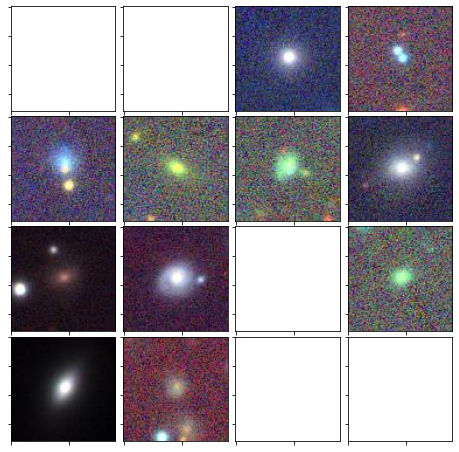

In [150]:
'''
---------------------------------------------------------------------
Show a selection of the ones cut by the astrometric error
---------------------------------------------------------------------
'''

import pylab 
import matplotlib.gridspec as gridspec
%matplotlib inline
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(xmatch_cut_out['ramean'].values[i],xmatch_cut_out['decmean'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
plt.savefig('removed_by_noise.pdf')

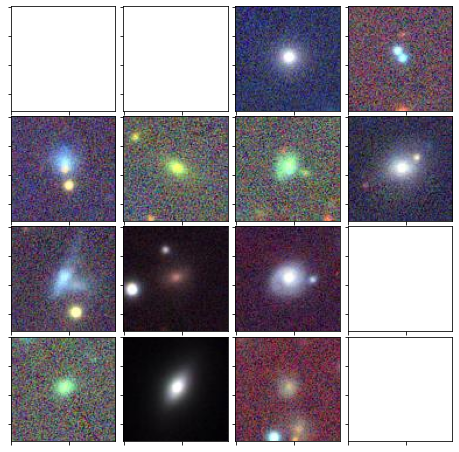

In [75]:
'''
---------------------------------------------------------------------
Show a selection of the ones cut by proper motion
---------------------------------------------------------------------
'''

import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(xmatch_cut_out_2['ramean'].values[i],xmatch_cut_out_2['decmean'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
plt.savefig('removed_by_proper_motion.pdf')

IndexError: index 9 is out of bounds for axis 0 with size 9

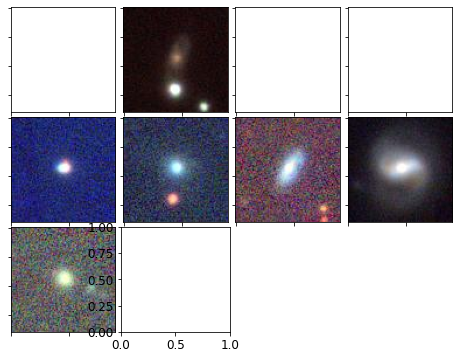

In [76]:
'''
---------------------------------------------------------------------
Show a selection of high noise, kept ones
---------------------------------------------------------------------
'''
xmatch_cut_1_low_noise=xmatch_cut[(xmatch_cut['ruwe']>2)]
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(xmatch_cut_1_low_noise['ramean'].values[i],xmatch_cut_1_low_noise['decmean'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

In [151]:
'''
---------------------------------------------------------------------
Loading in the FITS template 
---------------------------------------------------------------------
'''

template_hdulist = _fits.open('/home/sumedha/Documents/Projects/WEAVE/fitscatalog/WS2022B1-003_CatalogueTemplate.fits')
template_primary_hdu = template_hdulist[0]
template_hdu = template_hdulist[1]
template_column_names = [col.name for col in template_hdu.columns]

# Print all the columns we need to fill 
# ---------------------------------------------------------------------
print(template_column_names)

['CNAME', 'TARGSRVY', 'TARGPROG', 'TARGCAT', 'TARGID', 'TARGNAME', 'TARGPRIO', 'TARGUSE', 'TARGCLASS', 'PROGTEMP', 'OBSTEMP', 'GAIA_ID', 'GAIA_DR', 'GAIA_RA', 'GAIA_DEC', 'GAIA_EPOCH', 'GAIA_PMRA', 'GAIA_PMRA_ERR', 'GAIA_PMDEC', 'GAIA_PMDEC_ERR', 'GAIA_PARAL', 'GAIA_PARAL_ERR', 'HEALPIX', 'IFU_SPAXEL', 'IFU_PA', 'IFU_DITHER', 'MAG_G', 'MAG_G_ERR', 'MAG_R', 'MAG_R_ERR', 'MAG_I', 'MAG_I_ERR', 'GAIA_MAG_G', 'GAIA_MAG_G_ERR', 'GAIA_MAG_BP', 'GAIA_MAG_BP_ERR', 'GAIA_MAG_RP', 'GAIA_MAG_RP_ERR', 'APS_WL_MIN', 'APS_WL_MAX', 'APS_Z', 'APS_SIGMA', 'APS_TEMPL_LIB', 'APS_TEMPL_LIB_NORM', 'APS_PPXF_WL_MIN', 'APS_PPXF_WL_MAX', 'APS_PPXF_MOM', 'APS_PPXF_DEG_ADD', 'APS_PPXF_DEG_MULT', 'APS_PPXF_NUM_MC', 'APS_GAND_MODE', 'APS_GAND_ERR', 'APS_GAND_RED1', 'APS_GAND_RED2', 'APS_GAND_EBV', 'APS_LS_MODE', 'APS_LS_RES', 'APS_LS_NUM_MC', 'APS_SSP_NUM_WLKR', 'APS_SSP_NUM_CHAIN', 'APS_IFU_MASK', 'APS_IFU_TSSL_TYPE', 'APS_IFU_TSSL_TARG_SNR', 'APS_IFU_TSSL_MIN_SNR', 'APS_IFU_TSSL_COVAR', 'APS_IFU_SRC_ID', 'APS_IF

In [152]:
'''
---------------------------------------------------------------------
Editing the Extension headers 0 and 1
---------------------------------------------------------------------
'''

# Extension 0 Header

ext0_header=template_hdulist[0].header

#Set the catalogue submitter and CCs
ext0_header['TACALLOC']='WS2022B1-003' # changed after first submission
ext0_header['CAT_NME1']='Sumedha'
ext0_header['CAT_NME2']='Biswas'
ext0_header['CAT_MAIL']='sumedha.biswas@ru.nl'
ext0_header['CAT_CC']='p.jonker@sron.nl,morgan.fraser@ucd.ie'
print(repr(ext0_header))

# Extension 1 Header 

ext1_header=template_hdulist[1].header
print(repr(ext1_header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT WS2022B1-003 Catalogue Template                                         
DATAMVER= '8.00    '           / WEAVE Data Model Version                       
TRIMESTE= '2022B1  '           / Observing Trimester                            
TACALLOC= 'WS2022B1-003'       / Proposal identifier                            
TACID   = 'WS      '           / TAC identifiers                                
MAG_G_CM= '' / Survey specific mag column(s) used for MAG_G                     
MAG_R_CM= '' / Survey specific mag column(s) used for MAG_R                     
MAG_I_CM= '' / Survey specific mag column(s) used for MAG_I                     
STL_NME1= 'Peter   '        

In [153]:
'''
---------------------------------------------------------------------
Calculate Gaia magnitude errors
---------------------------------------------------------------------
'''
total_cut_df = xmatch_all

total_cut_df['phot_g_mean_mag_err']=1.086/total_cut_df['phot_g_mean_flux_over_error']
total_cut_df['phot_bp_mean_mag_err']=1.086/total_cut_df['phot_bp_mean_flux_over_error']
total_cut_df['phot_rp_mean_mag_err']=1.086/total_cut_df['phot_rp_mean_flux_over_error']

In [154]:
'''
Change column names, 
'''
def GLADE_ID(df):
    df["GLADE_ID"] = df["hyperleda_name"].fillna(df["GWGC"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["PGC"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["SDSS"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["2MASS"])
    
GLADE_ID(total_cut_df)

KeyError: 'GWGC'

In [155]:
print(total_cut_df.columns.tolist())

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra_xmatch', 'ra_error', 'dec_xmatch', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_match

In [168]:
total_cut_df = total_cut_df.reset_index(drop=True)
FITS_table_from_cat=total_cut_df[['source_id','our_id','designation','ra_gaia', 'dec_gaia', 'pmra', 'pmra_error',
                                  'pmdec', 'pmdec_error','parallax', 'parallax_error','phot_g_mean_mag',
                                  'phot_g_mean_mag_err','phot_bp_mean_mag','phot_bp_mean_mag_err',
                                  'phot_rp_mean_mag','phot_rp_mean_mag_err', 'gmeankronmag', 'gmeankronmagerr',
                                  'rmeankronmag', 'rmeankronmagerr','imeankronmag', 'imeankronmagerr',
                                  'objnamehms', 'ramean', 'decmean',
                                  'gmeankronmag', 'gmeankronmagerr','imeankronmag', 'imeankronmagerr',
                                  'rmeankronmag', 'rmeankronmagerr','ymeankronmag', 'ymeankronmagerr',
                                  'zmeankronmag', 'zmeankronmagerr',
                                  'ra_glade', 'dec_glade', 'glade_num', 'h', 'h_err','j', 'j_err',  'k', 'k_err',
                                  'ra_glade', 'dec_glade', 'glade_num','b_2', 'b_err'
                                ]]


FITS_table_from_cat.columns = ['COORDCAT','TARGID','GAIA_ID','GAIA_RA', 'GAIA_DEC', 'GAIA_PMRA', 'GAIA_PMRA_ERR', 
                               'GAIA_PMDEC', 'GAIA_PMDEC_ERR', 'GAIA_PARAL', 'GAIA_PARAL_ERR','GAIA_MAG_G', 
                               'GAIA_MAG_G_ERR', 'GAIA_MAG_BP', 'GAIA_MAG_BP_ERR', 
                               'GAIA_MAG_RP', 'GAIA_MAG_RP_ERR', 'MAG_G', 'MAG_G_ERR', 
                               'MAG_R', 'MAG_R_ERR', 'MAG_I', 'MAG_I_ERR',
                               'PS_ID', 'PS_RA', 'PS_DEC',
                               'PS_MAG_G', 'PS_MAG_G_ERR', 'PS_MAG_I', 'PS_MAG_I_ERR', 
                               'PS_MAG_R', 'PS_MAG_R_ERR', 'PS_MAG_Y', 'PS_MAG_Y_ERR', 'PS_MAG_Z', 'PS_MAG_Z_ERR',
                                'NIRCAT_RA',  'NIRCAT_DEC',  'NIRCAT_ID', 'NIRCAT_MAG_H', 'NIRCAT_MAG_H_ERR', 
                               'NIRCAT_MAG_J', 'NIRCAT_MAG_J_ERR', 'NIRCAT_MAG_K', 'NIRCAT_MAG_K_ERR',
                               'OPTCAT_RA', 'OPTCAT_DEC',   'OPTCAT_ID', 'OPTCAT_MAG_B', 'OPTCAT_MAG_B_ERR'
                              ]

FITS_table_from_cat.reset_index()
#survey identifier
FITS_table_from_cat['TARGSRVY']='WS2022B1-003'

#CNAME is set by WEAVE
FITS_table_from_cat['CNAME']=''

#optional personal name for programme/catalogue
FITS_table_from_cat['TARGPROG']='GW-galaxy'
FITS_table_from_cat['TARGCAT']='WS2022B1-003.fits'

#T for target, GALAXY
FITS_table_from_cat['TARGUSE']='T'
FITS_table_from_cat['TARGCLASS']='GALAXY'

# PROGTEMP for MOS LR 3x1020s 60min OB
FITS_table_from_cat['PROGTEMP']='11331'

#OBSTEMP for max airmass=1.8, moon dist=90 deg, 
#max sky brightness=20.5, max seeing = 1.3'', transparency=0.8
FITS_table_from_cat['OBSTEMP']='GAEAD'

#TARGNAME is the same as unique id
FITS_table_from_cat['TARGNAME']=FITS_table_from_cat['TARGID']

#TARGPRIO = 10.0 for GLADE galaxies
#For the rest, set according to 
FITS_table_from_cat['TARGPRIO']=float(10)

    
def DR (df):
    if df['source'] == 'GLADE' :
        return 'V2'
    else:
        return ''
def glade (df):
    if df['source'] == 'GLADE' :
        return 'GLADE'
    else:
        return ''
    
def gaia (df):
    if df['GAIA_ID']!='':
        return '3'
    else:
        return ''

def PS (df):
    if df['PS_ID']!='':
        return '2'
    else:
        return ''
    
# ID columns are strings
FITS_table_from_cat['GAIA_ID']=FITS_table_from_cat['GAIA_ID'].astype(str)
FITS_table_from_cat['PS_ID']=FITS_table_from_cat['PS_ID'].astype(str)
FITS_table_from_cat['OPTCAT_ID']=FITS_table_from_cat['OPTCAT_ID'].astype(str)
FITS_table_from_cat['NIRCAT_ID']=FITS_table_from_cat['NIRCAT_ID'].astype(str)

# Null values for ID columns should be empty strings
FITS_table_from_cat.loc[FITS_table_from_cat.GAIA_ID == 'nan', ['GAIA_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.NIRCAT_ID == 'nan', ['NIRCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.OPTCAT_ID == 'nan', ['OPTCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.PS_ID == 'nan', ['PS_ID']] = ''

# # only give NIRCAT/OPTCAT columns for GLADE galaxies.
# FITS_table_from_cat['NIRCAT_DR']=total_cut_df.apply (lambda total_cut_df: DR(total_cut_df), axis=1)
FITS_table_from_cat['OPTCAT_DR']=total_cut_df.apply (lambda total_cut_df: DR(total_cut_df), axis=1)
FITS_table_from_cat['NIRCAT']=total_cut_df.apply (lambda total_cut_df: glade(total_cut_df), axis=1)
FITS_table_from_cat['OPTCAT']=total_cut_df.apply (lambda total_cut_df: glade(total_cut_df), axis=1)

#Only give Gaia/PS columns for sources crossmatched with either.
FITS_table_from_cat['GAIA_DR']=FITS_table_from_cat.apply (lambda FITS_table_from_cat: gaia(FITS_table_from_cat), axis=1)
FITS_table_from_cat['PS_DR']=FITS_table_from_cat.apply (lambda FITS_table_from_cat: PS(FITS_table_from_cat), axis=1)
FITS_table_from_cat['GAIA_DR']='3'
FITS_table_from_cat['GAIA_EPOCH']=2016.0  
# PS nulls are -999 - set to nan
FITS_table_from_cat=FITS_table_from_cat.replace(-999.000000, np.nan)


# Set APS / IFU columns to the default by setting them to null

FITS_table_from_cat['APS_PPXF_MOM']=-1
FITS_table_from_cat['APS_FLAG'] =''
FITS_table_from_cat['IFU_SPAXEL']=''
FITS_table_from_cat['APS_Z']=np.nan
FITS_table_from_cat['APS_TEMPL_LIB']=''
FITS_table_from_cat['APS_GAND_EBV']=-1
FITS_table_from_cat['APS_GAND_ERR']=-1
FITS_table_from_cat['APS_TEMPL_LIB_NORM']=-1
FITS_table_from_cat['APS_IFU_TSSL_MIN_SNR'] =np.nan
FITS_table_from_cat['IFU_PA'] =np.nan
FITS_table_from_cat['IFU_DITHER'] =float(0)
FITS_table_from_cat['APS_WL_MIN'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_TYPE'] =''
FITS_table_from_cat['GENCAT_INFO'] =''
FITS_table_from_cat['APS_SSP_NUM_WLKR'] =-1
FITS_table_from_cat['APS_LS_NUM_MC'] =-1
FITS_table_from_cat['APS_PPXF_DEG_MULT'] =-1
FITS_table_from_cat['APS_GAND_MODE'] =-1
FITS_table_from_cat['APS_GAND_RED2'] =np.nan
FITS_table_from_cat['APS_PPXF_NUM_MC'] =-1
FITS_table_from_cat['APS_IFU_SRC_DEC']=np.nan
FITS_table_from_cat['APS_IFU_SRC_ID'] =''
FITS_table_from_cat['APS_LS_RES'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_COVAR'] =-1
FITS_table_from_cat['APS_SSP_NUM_CHAIN'] =-1
FITS_table_from_cat['HEALPIX'] =-1
FITS_table_from_cat['APS_LS_MODE'] =-1
FITS_table_from_cat['APS_WL_MAX'] =np.nan
FITS_table_from_cat['APS_IFU_MASK'] =-1
FITS_table_from_cat['APS_PPXF_DEG_ADD'] =-1
FITS_table_from_cat['APS_PPXF_WL_MAX'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_TARG_SNR'] =np.nan
FITS_table_from_cat['APS_GAND_RED1'] =np.nan
FITS_table_from_cat['APS_IFU_SRC_RA'] =np.nan
FITS_table_from_cat['APS_SIGMA'] =np.nan
FITS_table_from_cat['APS_PPXF_WL_MIN']=np.nan

# # add spec or phot z from GLADE
def glade_spec_z (df):
    if df['dist_flag']==3:
        return df['z']
    else:
        return np.nan
    
def glade_phot_z (df):
    if df['dist_flag']==1:
        return df['z']
    else:
        return np.nan
    
FITS_table_from_cat['PHOTOZCAT_Z']=total_cut_df.apply (lambda total_cut_df: glade_phot_z(total_cut_df), axis=1)
FITS_table_from_cat['SPECZCAT_Z']=total_cut_df.apply (lambda total_cut_df: glade_spec_z(total_cut_df), axis=1)

FITS_table_from_cat['PHOTOZCAT_DR']= np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), 'V2','')
FITS_table_from_cat['SPECZCAT_DR']= np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), 'V2','')
FITS_table_from_cat['PHOTOZCAT']= np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), 'GLADE','')
FITS_table_from_cat['SPECZCAT']= np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), 'GLADE','')

FITS_table_from_cat['PHOTOZCAT_ID'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_ID,'')
FITS_table_from_cat['SPECZCAT_ID'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_ID,'')
FITS_table_from_cat['PHOTOZCAT_RA'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_RA,np.nan)
FITS_table_from_cat['SPECZCAT_RA'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_RA,np.nan)
FITS_table_from_cat['PHOTOZCAT_DEC'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_DEC,np.nan)
FITS_table_from_cat['SPECZCAT_DEC'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_DEC,np.nan)

FITS_table_from_cat['PHOTOZCAT_ID']=FITS_table_from_cat['PHOTOZCAT_ID'].astype(str)
FITS_table_from_cat['SPECZCAT_ID']=FITS_table_from_cat['SPECZCAT_ID'].astype(str)
FITS_table_from_cat.loc[FITS_table_from_cat.PHOTOZCAT_ID == 'nan', ['PHOTOZCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.SPECZCAT_ID == 'nan', ['SPECZCAT_ID']] = ''


# Edits after the first submission/job report 

FITS_table_from_cat['NIRCAT_RA'] = np.nan
FITS_table_from_cat['NIRCAT_DEC'] = np.nan
FITS_table_from_cat['NIRCAT_DR'] = '2'
FITS_table_from_cat['NIRCAT_MAG_H'] = np.nan
FITS_table_from_cat['NIRCAT_MAG_H_ERR'] = np.nan
FITS_table_from_cat['NIRCAT_MAG_K'] = np.nan
FITS_table_from_cat['NIRCAT_MAG_K_ERR'] = np.nan
FITS_table_from_cat['NIRCAT_MAG_J'] = np.nan
FITS_table_from_cat['NIRCAT_MAG_J_ERR'] = np.nan
# FITS_table_from_cat['OPTCAT_DEC'] = np.nan
# FITS_table_from_cat['OPTCAT_RA'] = np.nan
FITS_table_from_cat['OPTCAT_MAG_B'] = np.nan
FITS_table_from_cat['OPTCAT_MAG_B_ERR'] = np.nan


# Edits after the second job report 
FITS_table_from_cat['OPTCAT'] = 'GLADE'
FITS_table_from_cat['OPTCAT_DR'] = '2'
FITS_table_from_cat['OPTCAT_RA'] = total_cut_df['ra_glade']
FITS_table_from_cat['OPTCAT_DEC'] = total_cut_df['dec_glade']
FITS_table_from_cat['OPTCAT_ID'] = total_cut_df['sdss_dr16q_name']
FITS_table_from_cat['NIRCAT'] = 'GLADE'

# Edits after the third job report 
FITS_table_from_cat['OPTCAT_DEC'] = np.nan
FITS_table_from_cat['OPTCAT_ID'] = ''
FITS_table_from_cat['OPTCAT_RA'] = np.nan


# Sort according to magnitude i.e. highest magnitude first (for first in order)

FITS_table_from_cat.sort_values(by='GAIA_MAG_G', ascending=True)

/tmp/ipykernel_123165/2532555085.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FITS_table_from_cat['TARGSRVY']='WS2022B1-003'
/tmp/ipykernel_123165/2532555085.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FITS_table_from_cat['CNAME']=''
/tmp/ipykernel_123165/2532555085.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,COORDCAT,TARGID,GAIA_ID,GAIA_RA,GAIA_DEC,GAIA_PMRA,GAIA_PMRA_ERR,GAIA_PMDEC,GAIA_PMDEC_ERR,GAIA_PARAL,GAIA_PARAL_ERR,GAIA_MAG_G,GAIA_MAG_G_ERR,GAIA_MAG_BP,GAIA_MAG_BP_ERR,GAIA_MAG_RP,GAIA_MAG_RP_ERR,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_I,MAG_I_ERR,PS_ID,PS_RA,PS_DEC,PS_MAG_G,PS_MAG_G_ERR,PS_MAG_I,PS_MAG_I_ERR,PS_MAG_R,PS_MAG_R_ERR,PS_MAG_Y,PS_MAG_Y_ERR,PS_MAG_Z,PS_MAG_Z_ERR,NIRCAT_RA,NIRCAT_DEC,NIRCAT_ID,NIRCAT_MAG_H,NIRCAT_MAG_H_ERR,NIRCAT_MAG_J,NIRCAT_MAG_J_ERR,NIRCAT_MAG_K,NIRCAT_MAG_K_ERR,OPTCAT_RA,OPTCAT_DEC,OPTCAT_ID,OPTCAT_MAG_B,OPTCAT_MAG_B_ERR,TARGSRVY,CNAME,TARGPROG,TARGCAT,TARGUSE,TARGCLASS,PROGTEMP,OBSTEMP,TARGNAME,TARGPRIO,OPTCAT_DR,NIRCAT,OPTCAT,GAIA_DR,PS_DR,GAIA_EPOCH,APS_PPXF_MOM,APS_FLAG,IFU_SPAXEL,APS_Z,APS_TEMPL_LIB,APS_GAND_EBV,APS_GAND_ERR,APS_TEMPL_LIB_NORM,APS_IFU_TSSL_MIN_SNR,IFU_PA,IFU_DITHER,APS_WL_MIN,APS_IFU_TSSL_TYPE,GENCAT_INFO,APS_SSP_NUM_WLKR,APS_LS_NUM_MC,APS_PPXF_DEG_MULT,APS_GAND_MODE,APS_GAND_RED2,APS_PPXF_NUM_MC,APS_IFU_SRC_DEC,APS_IFU_SRC_ID,APS_LS_RES,APS_IFU_TSSL_COVAR,APS_SSP_NUM_CHAIN,HEALPIX,APS_LS_MODE,APS_WL_MAX,APS_IFU_MASK,APS_PPXF_DEG_ADD,APS_PPXF_WL_MAX,APS_IFU_TSSL_TARG_SNR,APS_GAND_RED1,APS_IFU_SRC_RA,APS_SIGMA,APS_PPXF_WL_MIN,PHOTOZCAT_Z,SPECZCAT_Z,PHOTOZCAT_DR,SPECZCAT_DR,PHOTOZCAT,SPECZCAT,PHOTOZCAT_ID,SPECZCAT_ID,PHOTOZCAT_RA,SPECZCAT_RA,PHOTOZCAT_DEC,SPECZCAT_DEC,NIRCAT_DR
1336,2692490572384423936,200129m_11713,Gaia DR3 2692490572384423936,319.493408,2.892128,14.521819,0.027315,-18.647378,0.018111,2.954185,0.020321,6.574938,0.000233,7.394382,0.000932,5.686468,0.001632,19.661600,0.009656,17.198700,0.065012,NaN,NaN,PSX J211757.58+025408.8,319.489921,2.902474,19.661600,0.009656,NaN,NaN,17.198700,0.065012,15.431000,0.000005,18.573099,0.063195,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,WS2022B1-003,,GW-galaxy,WS2022B1-003.fits,T,GALAXY,11331,GAEAD,200129m_11713,10.0,2,GLADE,GLADE,3,2,2016.0,-1,,,NaN,,-1,-1,-1,NaN,NaN,0.0,NaN,,,-1,-1,-1,-1,NaN,-1,NaN,,NaN,-1,-1,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,NaN,NaN,NaN,NaN,2
986,1758320513897275008,190728_10119,Gaia DR3 1758320513897275008,315.494385,13.324671,5.998857,0.089666,-5.318295,0.075274,2.648491,0.105650,7.918163,0.000383,7.916826,0.000707,7.875598,0.000484,18.651800,0.047278,17.689199,0.080194,18.767000,0.094445,PSX J210156.66+131910.2,315.486113,13.319514,18.651800,0.047278,18.767000,0.094445,17.689199,0.080194,18.129000,0.061080,18.676600,0.079482,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,WS2022B1-003,,GW-galaxy,WS2022B1-003.fits,T,GALAXY,11331,GAEAD,190728_10119,10.0,2,GLADE,GLADE,3,2,2016.0,-1,,,NaN,,-1,-1,-1,NaN,NaN,0.0,NaN,,,-1,-1,-1,-1,NaN,-1,NaN,,NaN,-1,-1,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,NaN,NaN,NaN,NaN,2
7259,1758139094478718592,190728_9789,Gaia DR3 1758139094478718592,315.626221,12.597400,10.670431,0.019339,7.819726,0.015701,3.339915,0.022208,8.084820,0.000146,8.699647,0.000374,7.334667,0.000279,20.034401,0.088908,18.183001,0.211213,19.681400,0.093441,PSX J210231.97+123554.5,315.633243,12.598498,20.034401,0.088908,19.681400,0.093441,18.183001,0.211213,17.379400,0.073888,18.581301,0.083909,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,WS2022B1-003,,GW-galaxy,WS2022B1-003.fits,T,GALAXY,11331,GAEAD,190728_9789,10.0,2,GLADE,GLADE,3,2,2016.0,-1,,,NaN,,-1,-1,-1,NaN,NaN,0.0,NaN,,,-1,-1,-1,-1,NaN,-1,NaN,,NaN,-1,-1,-1,-1,NaN,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,NaN,NaN,NaN,NaN,2
11348,1784738479777290112,190728_15405,Gaia DR3 1784738479777290112,320.548096,16.918770,-2.987243,0.049221,-13.306970,0.036615,1.045637,0.052094,8.292722,0.000352,9.322064,0.001519,7.295815,0.000869,17.526600,0.027929,16.547501,0.207512,NaN,NaN,PSX J212213.56+165452.1,320.556524,16.914540,17.526600,0.027929,NaN,NaN,16.547501,0.207512,12.414800,0.000000,14.993900,0.004131,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,WS2022B1-003,,GW-galaxy,WS2022B1-003.fits,T,GALAXY,11331,GAEAD,190728_15405,10.0,2,GLADE,GLADE,3,2,2016.0,-1,,,NaN,,-1,-1,-1,NaN,NaN,0.0,NaN,,,-1,-1,-1,-1,NaN,-1,NaN,,N

In [144]:
type(FITS_table_from_cat)

pandas.core.frame.DataFrame

In [169]:
'''
---------------------------------------------------------------------
Set TARGPRIO based on magnitude and astrometric error
---------------------------------------------------------------------
'''

# check the magnitude of sources from PS1 and apply weights. If GLADE, set to 10.0.

FITS_table_from_cat['astrometric_excess_noise']=total_cut_df['astrometric_excess_noise']
FITS_table_from_cat['astrometric_excess_noise_sig']=total_cut_df['astrometric_excess_noise_sig']
FITS_table_from_cat['ruwe']=total_cut_df['ruwe']

mags=FITS_table_from_cat['PS_MAG_R'][FITS_table_from_cat['OPTCAT']=='']
minval= min(mags)
maxval= max(mags)

good_astro = FITS_table_from_cat[(FITS_table_from_cat['ruwe']<=2)]
mags_consid=good_astro['PS_MAG_R'][good_astro['OPTCAT']=='']
mags=good_astro['PS_MAG_R']
minval= np.nanmin(mags_consid)
maxval= np.nanmax(mags_consid)
good_astro['normalized']=(10-6)*(1.0-(mags-minval)/(maxval-minval))+6

bad_astro = FITS_table_from_cat[(FITS_table_from_cat['ruwe']>2)]
mags_consid=bad_astro['PS_MAG_R'][bad_astro['OPTCAT']=='']
mags=bad_astro['PS_MAG_R']
minval= np.nanmin(mags_consid)
maxval= np.nanmax(mags_consid)
bad_astro['normalized']=(6-1)*(1.0-(mags-minval)/(maxval-minval))+1

# no astro
no_astro = FITS_table_from_cat[(FITS_table_from_cat['ruwe'].isna())]
mags_consid=no_astro['PS_MAG_R'][no_astro['OPTCAT']=='']
mags=no_astro['PS_MAG_R']
minval= np.nanmin(mags_consid)
maxval= np.nanmax(mags_consid)
no_astro['normalized']=(10-1)*(1.0-(mags-minval)/(maxval-minval))+1
overall_astro=pd.concat([good_astro,bad_astro], axis=0)
overall_astro=pd.concat([overall_astro,no_astro], axis=0)
overall_astro = overall_astro.set_index('TARGID')
overall_astro = overall_astro.reindex(index=FITS_table_from_cat['TARGID'])
overall_astro = overall_astro.reset_index()
#good astrometric error
FITS_table_from_cat['TARGPRIO'] = np.where(overall_astro.COORDCAT=='PS1', overall_astro.normalized,float(10))
FITS_table_from_cat.loc[FITS_table_from_cat.COORDCAT == 'GLADE', ['TARGPRIO']] = float(10)

ValueError: min() arg is an empty sequence

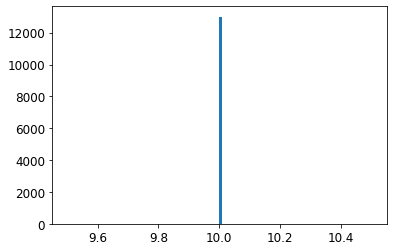

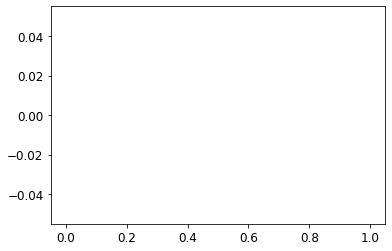

In [170]:
plt.figure(1)
plt.hist(FITS_table_from_cat['TARGPRIO'], bins=100)
plt.show()

plt.figure(2)
plt.hist(FITS_table_from_cat['ruwe'][FITS_table_from_cat['OPTCAT']==''], bins=100)
plt.show()

In [171]:
# Take PS or GLADE ra,dec,epoch
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5,ICRS
from astropy.io import ascii
# Read in decimal degree data, J2000 (FK5) coordinates
# ingest the coordinates
def precess(valra,valdec):
    c = SkyCoord(ra=valra, dec=valdec, unit='deg', frame='fk5')
    # print the coordinates
    # precess to J2015.5, i.e., Gaia reference system
    c_Gaia = c.transform_to(ICRS)
    # print the transformed coordinates
    ra=c_Gaia.ra.degree
    dec=c_Gaia.dec.degree
    return ra, dec


for t in range(0,len(FITS_table_from_cat)):
    if FITS_table_from_cat['GAIA_ID'][t]=='':
        if FITS_table_from_cat['PS_ID'][t]!='':
            #FITS_table_from_cat['GAIA_RA'][t]=FITS_table_from_cat['PS_RA'][t]
            #FITS_table_from_cat['GAIA_DEC'][t]=FITS_table_from_cat['PS_DEC'][t]
            FITS_table_from_cat['GAIA_RA'][t],  FITS_table_from_cat['GAIA_DEC'][t] = precess(FITS_table_from_cat['PS_RA'][t],FITS_table_from_cat['PS_DEC'][t])
            
            FITS_table_from_cat['GAIA_EPOCH'][t]=2016.0
        else:
            #FITS_table_from_cat['GAIA_RA'][t]=FITS_table_from_cat['OPTCAT_RA'][t]
            #FITS_table_from_cat['GAIA_DEC'][t]=FITS_table_from_cat['OPTCAT_DEC'][t]
            FITS_table_from_cat['GAIA_EPOCH'][t]=2016.0
            FITS_table_from_cat['GAIA_RA'][t],  FITS_table_from_cat['GAIA_DEC'][t] = precess(FITS_table_from_cat['OPTCAT_RA'][t],FITS_table_from_cat['OPTCAT_DEC'][t])

In [172]:
# give a list of the columns where the Mag_GRI column came from. 
mag_source_g=[]
mag_source_r=[]
mag_source_i=[]

for t in range(0,len(total_cut_df)):
    if total_cut_df['source'][t]=='GLADE':
        mag_source_g.append('PS_MAG_G')
        mag_source_r.append('PS_MAG_R')
        mag_source_i.append('PS_MAG_I')
    else:
        mag_source_g.append('PS_MAG_G')
        mag_source_r.append('PS_MAG_R')
        mag_source_i.append('PS_MAG_I')

ext0_header['MAG_G_CM']='|'.join(mag_source_g)
ext0_header['MAG_R_CM']='|'.join(mag_source_r)
ext0_header['MAG_I_CM']='|'.join(mag_source_i)

In [173]:
pd.set_option('display.max_columns', None)
FITS_table_from_cat=FITS_table_from_cat[template_column_names]

# put a cut of 1.0 on gaia_mag_bp_err as it seems to go above 1?

FITS_table_from_cat['GAIA_MAG_BP_ERR'][FITS_table_from_cat['GAIA_MAG_BP_ERR']>1]=np.nan
FITS_table_from_cat['GAIA_MAG_RP_ERR'][FITS_table_from_cat['GAIA_MAG_RP_ERR']>1]=np.nan
display(FITS_table_from_cat)

,CNAME,TARGSRVY,TARGPROG,TARGCAT,TARGID,TARGNAME,TARGPRIO,TARGUSE,TARGCLASS,PROGTEMP,OBSTEMP,GAIA_ID,GAIA_DR,GAIA_RA,GAIA_DEC,GAIA_EPOCH,GAIA_PMRA,GAIA_PMRA_ERR,GAIA_PMDEC,GAIA_PMDEC_ERR,GAIA_PARAL,GAIA_PARAL_ERR,HEALPIX,IFU_SPAXEL,IFU_PA,IFU_DITHER,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_I,MAG_I_ERR,GAIA_MAG_G,GAIA_MAG_G_ERR,GAIA_MAG_BP,GAIA_MAG_BP_ERR,GAIA_MAG_RP,GAIA_MAG_RP_ERR,APS_WL_MIN,APS_WL_MAX,APS_Z,APS_SIGMA,APS_TEMPL_LIB,APS_TEMPL_LIB_NORM,APS_PPXF_WL_MIN,APS_PPXF_WL_MAX,APS_PPXF_MOM,APS_PPXF_DEG_ADD,APS_PPXF_DEG_MULT,APS_PPXF_NUM_MC,APS_GAND_MODE,APS_GAND_ERR,APS_GAND_RED1,APS_GAND_RED2,APS_GAND_EBV,APS_LS_MODE,APS_LS_RES,APS_LS_NUM_MC,APS_SSP_NUM_WLKR,APS_SSP_NUM_CHAIN,APS_IFU_MASK,APS_IFU_TSSL_TYPE,APS_IFU_TSSL_TARG_SNR,APS_IFU_TSSL_MIN_SNR,APS_IFU_TSSL_COVAR,APS_IFU_SRC_ID,APS_IFU_SRC_RA,APS_IFU_SRC_DEC,APS_FLAG,NIRCAT,NIRCAT_DEC,NIRCAT_DR,NIRCAT_ID,NIRCAT_MAG_H,NIRCAT_MAG_H_ERR,NIRCAT_MAG_J,NIRCAT_MAG_J_ERR,NIRCAT_MAG_K,NIRCAT_MAG_K_ERR,NIRCAT_RA,OPTCAT,OPTCAT_DEC,OPTCAT_DR,OPTCAT_ID,OPTCAT_MAG_B,OPTCAT_MAG_B_ERR,OPTCAT_RA,PHOTOZCAT,PHOTOZCAT_DEC,PHOTOZCAT_DR,PHOTOZCAT_ID,PHOTOZCAT_RA,PHOTOZCAT_Z,PS_DEC,PS_DR,PS_ID,PS_MAG_G,PS_MAG_G_ERR,PS_MAG_I,PS_MAG_I_ERR,PS_MAG_R,PS_MAG_R_ERR,PS_MAG_Y,PS_MAG_Y_ERR,PS_MAG_Z,PS_MAG_Z_ERR,PS_RA,SPECZCAT,SPECZCAT_DEC,SPECZCAT_DR,SPECZCAT_ID,SPECZCAT_RA,SPECZCAT_Z
0,,WS2022B1-003,GW-galaxy,WS2022B1-003.fits,200129m_4401,200129m_4401,10.0,T,GALAXY,11331,GAEAD,Gaia DR3 1733370636556193024,3,318.394775,5.398113,2016.0,-6.113710,1.065975,-7.055337,0.779014,0.455649,1.105023,-1,,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,20.530697,0.007887,21.181820,0.178200,19.651340,0.100325,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,GLADE,NaN,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLADE,NaN,2,,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN
1,,WS2022B1-003,GW-galaxy,WS2022B1-003.fits,190728_7326,190728_7326,10.0,T,GALAXY,11331,GAEAD,Gaia DR3 1756508072056651520,3,314.681396,10.427406,2016.0,-4.531201,0.694574,-10.349764,0.495947,1.779168,0.687152,-1,,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,20.311872,0.004282,21.102936,0.138773,19.208551,0.046656,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,GLADE,NaN,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLADE,NaN,2,,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN
2,,WS2022B1-003,GW-galaxy,WS2022B1-003.fits,190728_11330,190728_11330,10.0,T,GALAXY,11331,GAEAD,Gaia DR3 1759135797473873536,3,317.955322,13.861950,2016.0,-11.549770,0.515631,-1.191657,0.408713,0.244507,0.556288,-1,,NaN,0.0,18.999599,0.012594,17.915199,0.019647,17.411900,0.008662,20.121252,0.004514,21.171474,0.097737,18.953783,0.029094,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,GLADE,NaN,2,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLADE,NaN,2,,NaN,NaN,NaN,,NaN,,,NaN,NaN,13.872836,2,PSX J211146.55+135222.2,18.999599,0.012594,17.411900,0.008662,17.915199,0.019647,17.055401,0.024207,17.128700,0.007503,317.943991,,NaN,,,NaN,NaN
3,,WS2022B1-003,GW-galaxy,WS2022B1-003.fits,190728_1604,190728_1604,10.0,T,GALAXY,11331,GAEAD,Gaia DR3 1736095531313197568,3,311.846924,6.692254,2016.0,8.260699,0.309890,-1.506985,0.280284,1.334970,0.324016,-1,,NaN,0.0,19.494200,0.028965,19.393000,0.092454,19.627300,0.104534,19.308456,0.002372,20.773455,0.076058,18.126865,0.015094,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,GLADE,NaN,2,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLADE,NaN,2,,NaN,NaN,NaN,,NaN,,,NaN,NaN,6.695567,2,PSX J204723.26+064144.0,19.494200,0.028965,19.627300,0.104534,19.393000,0.092454,NaN,NaN,19.683599,0.032842,311.846944,,NaN,,,NaN,NaN
4,,WS2022B1-003,GW-galaxy,WS2022B1-003.fits,190728_7078,190728_7078,10.0,T,GALAXY,11331,GAEAD,Gaia DR3 1751531579350333824,3,313.121338,10.730982,2016.0,-1.721783,0.608071,-2.117438,0.485627,0.500969,0.621055,-1,,NaN,0.0,19.124100,0.01

In [166]:
import datetime as _datetime

from astropy.io import fits as _fits


def populate_fits_table_template(fits_template, data_dict, output_filename,
                                 header, update_datetime=True,
                                 checksum=True, overwrite=False):
    """
    Populate a FITS table template with the provided data.

    Parameters
    ----------
    fits_template : list of str
        A FITS template with a primary HDU and a first extension with a table.
    data_dict : dict
        A dictionary with the data. Its keys should contain the name of the
        columns of the table in the first extension of the FITS template. Its
        values should be array-like with the data to populate the table.
    output_filename : str
        The name of the output file which will be created.
    primary_kwds : dict, optional
        A dictionary with a list of keywords and their corresponding values
        which will be written a in the primary header (updated or added).
    update_datetime : bool, optional
        Update DATETIME keyword in the output file.
    checksum : bool, optional
        Add CHECKSUM and DATASUM keywords in the output file.
    overwrite : bool, optional
        Overwrite the output FITS file.
    """
    
    # Read the FITS template
    
    template_hdulist = _fits.open(fits_template)
    template_primary_hdu = template_hdulist[0]
    template_hdu = template_hdulist[1]
    
    # Check that all the columns are available in the dictionary with the data
    
    template_column_names = [col.name for col in template_hdu.columns]
    
    for col_name in template_column_names:
        assert col_name in data_dict.keys()
    
    # Create list of columns as described in the template populated with the
    # provided data
    
    column_list = []

    for col in template_hdu.columns:
        
        column = _fits.Column(name=col.name, format=col.format,
                             disp=col.disp, unit=col.unit, null=col.null,
                             array=list(data_dict[col.name].values()))
        
        column_list.append(column)
    
    
    # Create a HDU from the column list
    
    coldefs = _fits.ColDefs(column_list)

    hdu = _fits.BinTableHDU.from_columns(coldefs)
    
    # Copy the header from the template
    
    hdu.header = template_hdu.header
    
    # Create the primary extension and populate it with the provided information
    
    primary_hdu = template_primary_hdu
    
    #for kwd in primary_kwds.keys():
     #   primary_hdu.header[kwd] = primary_kwds[kwd]
    primary_hdu = header
    # Update the keyword DATETIME if requested (and it exists)
    
    if (update_datetime is True) and ('DATETIME' in primary_hdu.keys()):
        datetime_str = _datetime.datetime.utcnow().strftime(
                           '%Y-%m-%d %H:%M:%S.%f')
        primary_hdu['DATETIME'] = datetime_str
    primary_hdu=_fits.PrimaryHDU(header=primary_hdu)
    # Create a HDU list and save it to a file
    
    hdulist = _fits.HDUList([primary_hdu, hdu])
    hdulist.writeto(output_filename, checksum=checksum, overwrite=overwrite)
    

In [174]:
data_dicts=FITS_table_from_cat.to_dict()
ext0_header['CAT_NME1']='Sumedha'
ext0_header['CAT_NME2']='Biswas'
ext0_header['CAT_MAIL']='sumedha.biswas@ru.nl'
ext0_header['CAT_CC']='p.jonker@sron.nl,morgan.fraser@ucd.ie'

ext0_header['MAG_G_CM']='PS_MAG_G'
ext0_header['MAG_R_CM']='PS_MAG_R'
ext0_header['MAG_I_CM']='PS_MAG_I'

prim_header=ext0_header
# A dictionary of the catalogue
# A dictionary of the keywords for primary extension
populate_fits_table_template('/home/sumedha/Documents/Projects/WEAVE/fitscatalog_v2/WS2022B1-003_CatalogueTemplate.fits', data_dicts, 'WS2022B1-003.fits',
                                 prim_header, update_datetime=True,
                                 checksum=True, overwrite=True)

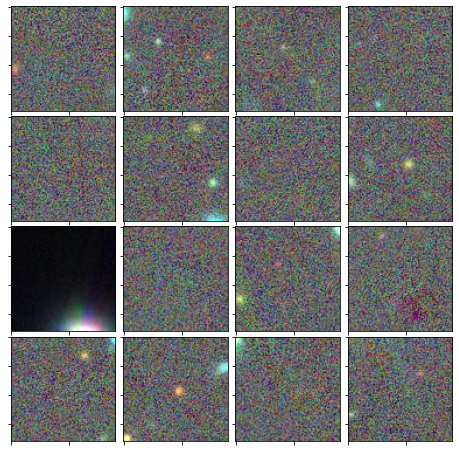

In [91]:
'''
---------------------------------------------------------------------
Show some PS1 DR2 sources with highest priority
---------------------------------------------------------------------
'''

FITS_table_from_cat['ruwe']=total_cut_df['ruwe']
sorted_ps1=FITS_table_from_cat[(FITS_table_from_cat['OPTCAT']=='') & (FITS_table_from_cat['ruwe'].notna()) ].sort_values(by=['TARGPRIO'], ascending=False)

import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(sorted_ps1['GAIA_RA'].values[i+10],sorted_ps1['GAIA_DEC'].values[i+10],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
plt.savefig('PS_high_TARGPRIO.pdf')

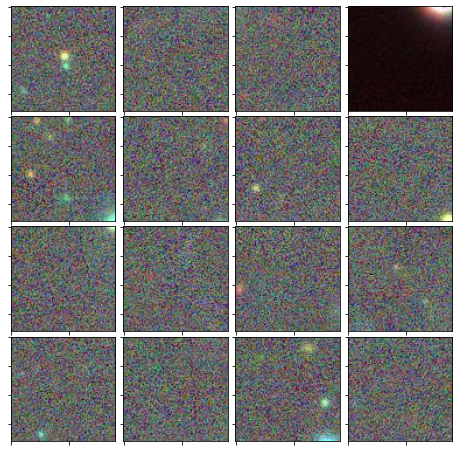

In [92]:
'''
---------------------------------------------------------------------
Show some PS1 DR2 sources with lowest priority (with noise)
---------------------------------------------------------------------
'''

sorted_ps1_6=FITS_table_from_cat[(FITS_table_from_cat['OPTCAT']=='') & (FITS_table_from_cat['ruwe'].notna()) ].sort_values(by=['TARGPRIO'])
import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(sorted_ps1_6['GAIA_RA'].values[i],sorted_ps1_6['GAIA_DEC'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
plt.savefig('PS_low_TARGPRIO.pdf')

IndexError: index 0 is out of bounds for axis 0 with size 0

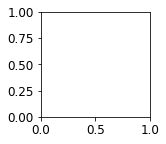

In [93]:
'''
---------------------------------------------------------------------
Show some GLADE sources
---------------------------------------------------------------------
'''

sorted_glade=FITS_table_from_cat[FITS_table_from_cat['OPTCAT']!='']
import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0

    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(sorted_glade['GAIA_RA'].values[i],sorted_glade['GAIA_DEC'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

In [104]:
# Checking the number of targets for each source

gw = FITS_table_from_cat.TARGID.tolist()

for i in range(0, len(gw)):
    if gw[i] == '200129m_*':
        print(yes)